In [7]:
%matplotlib inline



# Generating Cluster Graphs

This example shows how to find the communities in a graph, then contract each community into a single node using :class:`igraph.clustering.VertexClustering`. For this tutorial, we'll use the *Donald Knuth's Les Miserables Network*, which shows the coapperances of characters in the novel *Les Miserables*.


In [8]:
import igraph as ig
import matplotlib.pyplot as plt

We begin by load the graph from file. The file containing this network can be
downloaded [here](http://www-personal.umich.edu/~mejn/netdata/).



In [9]:
g = ig.load("./lesmis/lesmis.gml")

Now that we have a graph in memory, we can generate communities using
:meth:`igraph.Graph.community_edge_betweenness` to separate out vertices into
clusters. (For a more focused tutorial on just visualising communities, check
out `tutorials-visualize-communities`).



In [10]:
communities = g.community_edge_betweenness()

For plots, it is convenient to convert the communities into a VertexClustering:



In [11]:
communities = communities.as_clustering()

We can also easily print out who belongs to each community:



In [12]:
for i, community in enumerate(communities):
    print(f"Community {i}:")
    for v in community:
        print(f"\t{g.vs[v]['label']}")

Community 0:
	Myriel
	Napoleon
	MlleBaptistine
	MmeMagloire
	CountessDeLo
	Geborand
	Champtercier
	Cravatte
	Count
	OldMan
Community 1:
	Labarre
	Valjean
	MmeDeR
	Isabeau
	Gervais
	Bamatabois
	Simplice
	Scaufflaire
	Woman1
	Judge
	Champmathieu
	Brevet
	Chenildieu
	Cochepaille
Community 2:
	Marguerite
	Tholomyes
	Listolier
	Fameuil
	Blacheville
	Favourite
	Dahlia
	Zephine
	Fantine
	Perpetue
Community 3:
	MmeThenardier
	Thenardier
	Javert
	Pontmercy
	Eponine
	Anzelma
	Gueulemer
	Babet
	Claquesous
	Montparnasse
	Brujon
Community 4:
	Cosette
	Woman2
	Gillenormand
	Magnon
	MlleGillenormand
	MmePontmercy
	MlleVaubois
	LtGillenormand
	BaronessT
	Toussaint
Community 5:
	Fauchelevent
	MotherInnocent
	Gribier
Community 6:
	Boulatruelle
Community 7:
	Jondrette
	MmeBurgon
Community 8:
	Gavroche
	Marius
	Mabeuf
	Enjolras
	Combeferre
	Prouvaire
	Feuilly
	Courfeyrac
	Bahorel
	Bossuet
	Joly
	Grantaire
	MmeHucheloup
Community 9:
	MotherPlutarch
Community 10:
	Child1
	Child2


Finally we can proceed to plotting the graph. In order to make each community
stand out, we set "community colors" using an igraph palette:



In [13]:
num_communities = len(communities)
palette1 = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    g.vs[community]["color"] = i
    community_edges = g.es.select(_within=community)
    community_edges["color"] = i

We can use a dirty hack to move the labels below the vertices ;-)



In [14]:
g.vs["label"] = ["\n\n" + label for label in g.vs["label"]]

Finally, we can plot the communities:



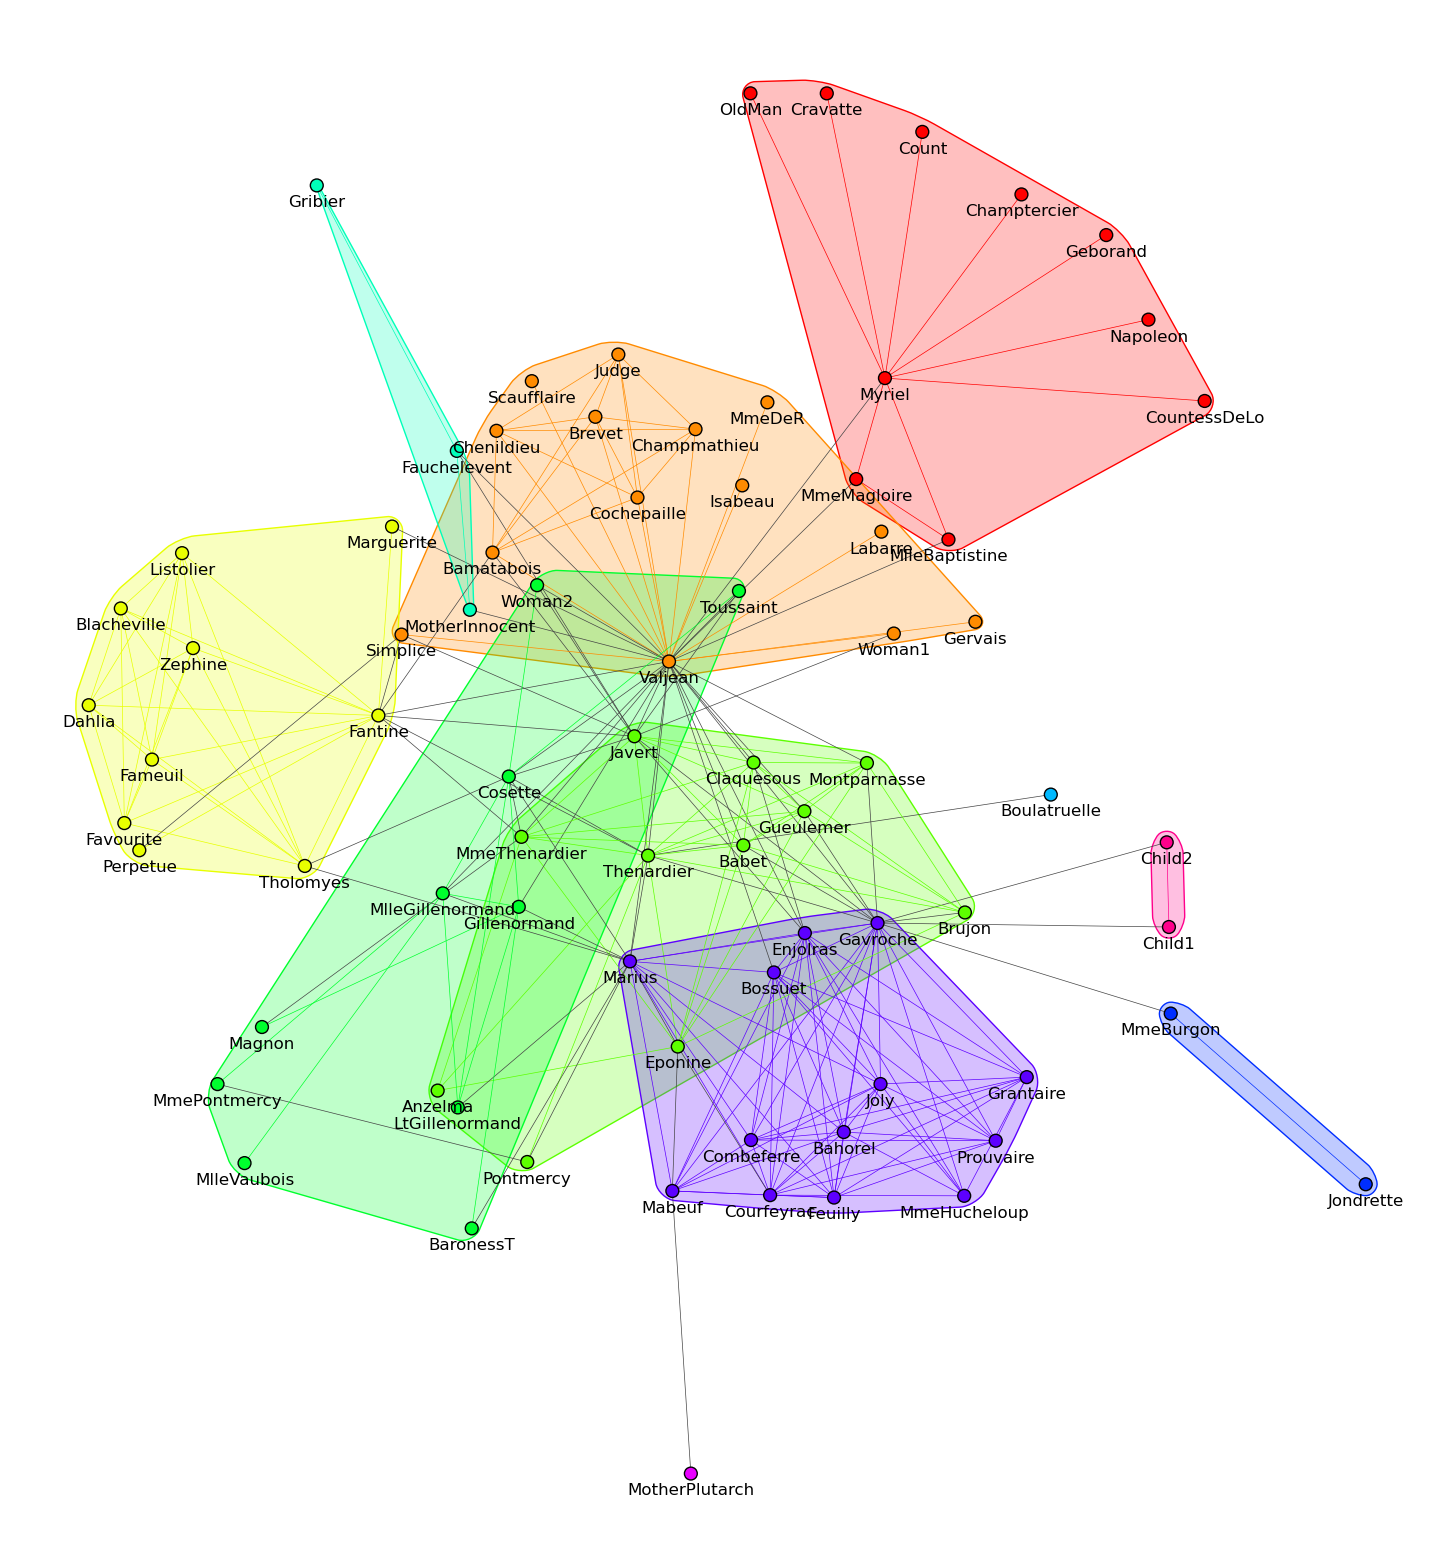

In [15]:
fig1, ax1 = plt.subplots()
ig.plot(
    communities,
    target=ax1,
    mark_groups=True,
    palette=palette1,
    vertex_size=0.1,
    edge_width=0.5,
)
fig1.set_size_inches(20, 20)

Now let's try and contract the information down, using only a single vertex
to represent each community. We start by defining x, y, and size attributes
for each node in the original graph:



In [16]:
layout = g.layout_kamada_kawai()
g.vs["x"], g.vs["y"] = list(zip(*layout))
g.vs["size"] = 1
g.es["size"] = 1

Then we can generate the cluster graph that compresses each community into a
single, "composite" vertex using
:meth:`igraph.VertexClustering.cluster_graph`:



In [17]:
cluster_graph = communities.cluster_graph(
    combine_vertices={
        "x": "mean",
        "y": "mean",
        "color": "first",
        "size": "sum",
    },
    combine_edges={
        "size": "sum",
    },
)

<div class="alert alert-info"><h4>Note</h4><p>We took the mean of x and y values so that the nodes in the cluster
     graph are placed at the centroid of the original cluster.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>``mean``, ``first``, and ``sum`` are all built-in collapsing functions,
    along with ``prod``, ``median``, ``max``, ``min``, ``last``, ``random``.
    You can also define your own custom collapsing functions, which take in a
    list and return a single element representing the combined attribute
    value. For more details on igraph contraction, see
    :meth:`igraph.GraphBase.contract_vertices`.</p></div>



Finally, we can assign colors to the clusters and plot the cluster graph,
including a legend to make things clear:



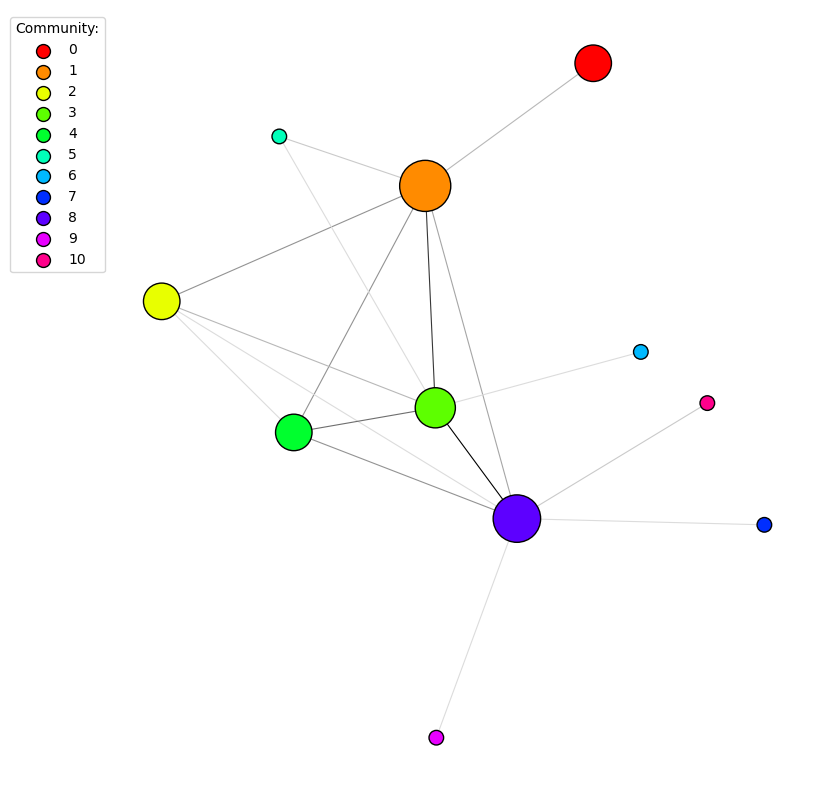

In [18]:
palette2 = ig.GradientPalette("gainsboro", "black")
g.es["color"] = [palette2.get(int(i)) for i in ig.rescale(cluster_graph.es["size"], (0, 255), clamp=True)]

fig2, ax2 = plt.subplots()
ig.plot(
    cluster_graph,
    target=ax2,
    palette=palette1,
    # set a minimum size on vertex_size, otherwise vertices are too small
    vertex_size=[max(0.2, size / 20) for size in cluster_graph.vs["size"]],
    edge_color=g.es["color"],
    edge_width=0.8,
)

# Add a legend
legend_handles = []
for i in range(num_communities):
    handle = ax2.scatter(
        [], [],
        s=100,
        facecolor=palette1.get(i),
        edgecolor="k",
        label=i,
    )
    legend_handles.append(handle)

ax2.legend(
    handles=legend_handles,
    title='Community:',
    bbox_to_anchor=(0, 1.0),
    bbox_transform=ax2.transAxes,
)

fig2.set_size_inches(10, 10)